In [1]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import albumentations
import numpy as np
import tqdm
from sklearn.metrics import accuracy_score

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)


In [2]:
%matplotlib inline

# Constants

In [3]:
N_AUGMENTS = 5
LEARNING_RATE = 0.001
GAMMA = 0.7
BATCH_SIZE = 128
EPOCHS = 20
SAMPLING_STRATEGY = 'HardNegativePair'
NEGATIVES_COUNT = N_AUGMENTS + 1

# Modules

In [22]:
class L2Normalization(nn.Module):
    def __init__(self):
        super(L2Normalization, self).__init__()

    def forward(self, input):
        return input.div(torch.norm(input, dim=1).view(-1, 1))
    
    
def outer_pairwise_distance(A, B=None):
    """
        Compute pairwise_distance of Tensors
            A (size(A) = n x d, where n - rows count, d - vector size) and
            B (size(A) = m x d, where m - rows count, d - vector size)
        return matrix C (size n x m), such as C_ij = distance(i-th row matrix A, j-th row matrix B)

        if only one Tensor was given, computer pairwise distance to itself (B = A)
    """

    if B is None: B = A

    max_size = 2 ** 26
    n = A.size(0)
    m = B.size(0)
    d = A.size(1)

    if n * m * d <= max_size or m == 1:

        return torch.pairwise_distance(
            A[:, None].expand(n, m, d).reshape((-1, d)),
            B.expand(n, m, d).reshape((-1, d))
        ).reshape((n, m))

    else:

        batch_size = max(1, max_size // (n * d))
        batch_results = []
        for i in range((m - 1) // batch_size + 1):
            id_left = i * batch_size
            id_rigth = min((i + 1) * batch_size, m)
            batch_results.append(outer_pairwise_distance(A, B[id_left:id_rigth]))

        return torch.cat(batch_results, dim=1)
    
def outer_cosine_similarity(A, B=None):
    """
        Compute cosine_similarity of Tensors
            A (size(A) = n x d, where n - rows count, d - vector size) and
            B (size(A) = m x d, where m - rows count, d - vector size)
        return matrix C (size n x m), such as C_ij = cosine_similarity(i-th row matrix A, j-th row matrix B)

        if only one Tensor was given, computer pairwise distance to itself (B = A)
    """

    if B is None: B = A

    max_size = 2 ** 32
    n = A.size(0)
    m = B.size(0)
    d = A.size(1)

    if n * m * d <= max_size or m == 1:

        A_norm = torch.div(A.transpose(0, 1), A.norm(dim=1)).transpose(0, 1)
        B_norm = torch.div(B.transpose(0, 1), B.norm(dim=1)).transpose(0, 1)
        return torch.mm(A_norm, B_norm.transpose(0, 1))

    else:

        batch_size = max(1, max_size // (n * d))
        batch_results = []
        for i in range((m - 1) // batch_size + 1):
            id_left = i * batch_size
            id_rigth = min((i + 1) * batch_size, m)
            batch_results.append(outer_cosine_similarity(A, B[id_left:id_rigth]))

        return torch.cat(batch_results, dim=1)
    
def metric_Recall_top_K(X, y, K, metric='cosine'):
    """
        calculate metric R@K
        X - tensor with size n x d, where n - number of examples, d - size of embedding vectors
        y - true labels
        N - count of closest examples, which we consider for recall calcualtion
        metric: 'cosine' / 'euclidean'.
            !!! 'euclidean' - to slow for datasets bigger than 100K rows
    """
    res = []

    n = X.size(0)
    d = X.size(1)
    max_size = 2 ** 32
    batch_size = max(1, max_size // (n*d))

    with torch.no_grad():

        for i in range(1 + (len(X) - 1) // batch_size):

            id_left = i*batch_size
            id_right = min((i+1)*batch_size, len(y))
            y_batch = y[id_left:id_right]

            if metric == 'cosine':
                pdist = -1 * outer_cosine_similarity(X, X[id_left:id_right])
            elif metric == 'euclidean':
                pdist = outer_pairwise_distance(X, X[id_left:id_right])
            else:
                raise AttributeError(f'wrong metric "{metric}"')

            values, indices = pdist.topk(K + 1, 0, largest=False)

            y_rep = y_batch.repeat(K, 1)
            res.append((y[indices[1:]] == y_rep).sum().item())

    return np.sum(res) / len(y) / K

# Sub Structures

In [5]:
class PairSelector:
    """
    Implementation should return indices of positive pairs and negative pairs that will be passed to compute
    Contrastive Loss
    return positive_pairs, negative_pairs
    """

    def __init__(self):
        pass

    def get_pairs(self, embeddings, labels):
        raise NotImplementedError
        
class HardNegativePairSelector(PairSelector):
    """
    Generates all possible possitive pairs given labels and
         neg_count hardest negative example for each example
    """
    def __init__(self, neg_count = 1):
        super(HardNegativePairSelector, self).__init__()
        self.neg_count = neg_count

    def get_pairs(self, embeddings, labels):
        
        # construct matrix x, such as x_ij == 0 <==> labels[i] == labels[j]
        n = labels.size(0)
        x = labels.expand(n,n) - labels.expand(n,n).t()        
            
        # positive pairs
        positive_pairs = torch.triu((x == 0).int(), diagonal = 1).nonzero()
        
        # hard negative minning
        mat_distances = outer_pairwise_distance(embeddings.detach()) # pairwise_distance
        
        upper_bound = int((2*n) ** 0.5) + 1
        mat_distances = ((upper_bound - mat_distances) * (x != 0).type(mat_distances.dtype)) # filter: get only negative pairs
        
        values, indices = mat_distances.topk(k = self.neg_count, dim = 0, largest = True)
        negative_pairs = torch.stack([
            torch.arange(0,n, dtype = indices.dtype, device = indices.device).repeat(self.neg_count),
            torch.cat(indices.unbind(dim = 0))
        ]).t()

        return positive_pairs, negative_pairs
        
def get_sampling_strategy(params='HardNegativePair'):
    if params == 'HardNegativePair':
        kwargs = {
            'neg_count' : NEGATIVES_COUNT,
        }
        kwargs = {k:v for k,v in kwargs.items() if v is not None}
        sampling_strategy = HardNegativePairSelector(**kwargs)
        return sampling_strategy
    return None

# DATASETS/MODELS

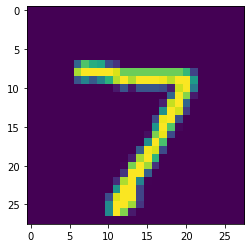

In [6]:
mnist_train_dataset = torchvision.datasets.MNIST('/mnt/data/molchanov/datasets/mnist', 
                                           train=True, 
                                           transform=None, 
                                           target_transform=None, 
                                           download=True)

mnist_test_dataset = torchvision.datasets.MNIST('/mnt/data/molchanov/datasets/mnist', 
                                           train=False, 
                                           transform=None, 
                                           target_transform=None, 
                                           download=True)

# -------------------------------------------------------------------------------------------------

# very slow
def mnist_augmentation(p=1):
    return Compose([
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=1),
        OneOf([
            MotionBlur(p=.33),
            MedianBlur(blur_limit=3, p=0.33),
            Blur(blur_limit=3, p=0.33),
        ], p=1),
        OneOf([
            OpticalDistortion(p=0.33),
            GridDistortion(p=0.33),
            IAAPiecewiseAffine(p=0.33)
        ], p=1),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=1),
    ], p=p)


def mnist_torch_augmentation(p=1):
    return torchvision.transforms.Compose([
        transforms.RandomChoice([
            transforms.RandomAffine(degrees=7, 
                                translate=(0.1, 0.1), 
                                scale=(0.9, 0.9), 
                                shear=None, 
                                resample=False, 
                                fillcolor=0),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3)
        ]),
        transforms.ColorJitter(brightness=0.7, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
    ])
plt.imshow(mnist_test_dataset[0][0])

# -------------------------------------------------------------------------------------------------

class MnistClassificationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.norm = L2Normalization()

    def forward(self, x):
        if len(x.size()) == 4:
            x = x[:, -1, :, :].unsqueeze(1) # get augmented image
        else:
            x = x.unsqueeze(1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = self.norm(x)
        return output
    
# --------------------------------------------------------------------------------------------------

class MnistMetricLearningNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 256)
        self.fc2 = nn.Linear(256, 32)

    def forward(self, x):
        x = x.view(-1, 1, x.size(-2), x.size(-1)) # b, augs, x, y -> b*augs, 1, x, y
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

Files already downloaded and verified
Files already downloaded and verified


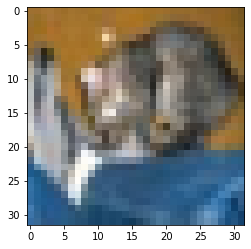

In [7]:
cifar10_train_dataset = torchvision.datasets.CIFAR10('/mnt/data/molchanov/datasets/cifar10', 
                                               train=True, 
                                               transform=None, 
                                               target_transform=None, 
                                               download=True)

cifar10_test_dataset = torchvision.datasets.CIFAR10('/mnt/data/molchanov/datasets/cifar10', 
                                               train=False, 
                                               transform=None, 
                                               target_transform=None, 
                                               download=True)

plt.imshow(cifar10_test_dataset[0][0])

Files already downloaded and verified
Files already downloaded and verified


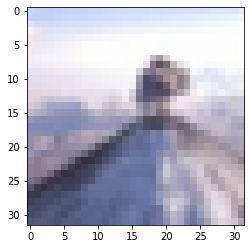

In [8]:
cifar100_train_dataset = torchvision.datasets.CIFAR100('/mnt/data/molchanov/datasets/cifar100', 
                                               train=True, 
                                               transform=None, 
                                               target_transform=None, 
                                               download=True)

cifar100_test_dataset = torchvision.datasets.CIFAR100('/mnt/data/molchanov/datasets/cifar100', 
                                               train=False, 
                                               transform=None, 
                                               target_transform=None, 
                                               download=True)

plt.imshow(cifar100_test_dataset[0][0])

# Augmentation Dataset/Dataloader

In [9]:
class MetrLearnDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, augmenter, n_augments=10):
        self.data = dataset
        self.aug = augmenter
        self.n_augments = n_augments
        
    def draw(self, idx):
        imgs, lbl = self[idx]
        print(imgs.shape, lbl)
        fig = plt.figure()
        rows, columns = 1, imgs.shape[0]
        for i in range(imgs.shape[0]):
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(imgs[i])
        plt.show()
        
    def __len__(self):
        return len(self.data)

    '''
    def __getitem__(self, idx):
        img, lbl = self.data[idx]
        imgs = [np.array(img)] + [self.aug(image=np.array(img))['image'] for i in range(self.n_augments)]
        b_img = np.stack(imgs, axis=0)
        return b_img, lbl
    '''
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx]
        imgs = [transforms.ToTensor()(img)] + [self.aug(img) for i in range(self.n_augments)]
        b_img = torch.stack(imgs).squeeze()
        return b_img, lbl
        
    
def get_mnist_train_loader(batch_size, n_augments=4):
    data_train = MetrLearnDataset(dataset=mnist_train_dataset, 
                            augmenter=mnist_torch_augmentation(p=1), 
                            n_augments=n_augments)
    
    train_data_loader = torch.utils.data.DataLoader(data_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=16)
    return train_data_loader
    
def get_mnist_test_loader(batch_size, n_augments=4):
    data_test = MetrLearnDataset(dataset=mnist_test_dataset, 
                            augmenter=mnist_torch_augmentation(p=1), 
                            n_augments=n_augments)
        
    test_data_loader = torch.utils.data.DataLoader(data_test,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=5)
    return test_data_loader

torch.Size([6, 28, 28]) 6


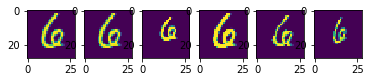

CPU times: user 529 ms, sys: 0 ns, total: 529 ms
Wall time: 526 ms


In [10]:
%%time
data = MetrLearnDataset(dataset=mnist_test_dataset, 
                        augmenter=mnist_torch_augmentation(p=1), 
                        n_augments=N_AUGMENTS)
data.draw(123)

# Losses

In [11]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    
    "Signature verification using a siamese time delay neural network", NIPS 1993
    https://papers.nips.cc/paper/769-signature-verification-using-a-siamese-time-delay-neural-network.pdf
    """

    def __init__(self, margin, pair_selector):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = pair_selector

    def forward(self, embeddings, target):
        
        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        positive_loss = F.pairwise_distance(embeddings[positive_pairs[:, 0]], embeddings[positive_pairs[:, 1]]).pow(2)
        
        negative_loss = F.relu(
            self.margin - F.pairwise_distance(embeddings[negative_pairs[:, 0]], embeddings[negative_pairs[:, 1]])
        ).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)
        
        return loss.sum(), len(positive_pairs) + len(negative_pairs)

# Train Info

In [12]:
class LaunchInfo:
    
    def __init__(self, model, loss, optimizer, scheduler, train_loader, test_loader, epochs, device, mode):
        self.model = model
        self.loss = loss
        self.epochs = epochs
        self.mode = mode
        
        if optimizer is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
            
        if scheduler is not None:
            self.scheduler = scheduler
        else:
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer,
                                                             step_size=1,
                                                             gamma=GAMMA)
            
        self.train_loader = train_loader
        self.test_loader = test_loader
        
        if device == 'cuda':
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
            
        self.model.to(device)
        self.loss.to(device)
        
# -------------------------- predefind configs --------------------------------
        
mnist_classification_lunch_info = LaunchInfo(model=MnistClassificationNet(), 
                                             loss=torch.nn.NLLLoss(), 
                                             optimizer=None, 
                                             scheduler=None, 
                                             train_loader=get_mnist_train_loader(batch_size=BATCH_SIZE, 
                                                                                 n_augments=N_AUGMENTS), 
                                             test_loader=get_mnist_test_loader(batch_size=BATCH_SIZE, 
                                                                               n_augments=N_AUGMENTS), 
                                             epochs=EPOCHS, 
                                             device='cuda',
                                             mode='classification')
    
mnist_metriclearning_lunch_info = LaunchInfo(model=MnistMetricLearningNet(), 
                                             loss=ContrastiveLoss(margin=0.1, 
                                                                  pair_selector=get_sampling_strategy(SAMPLING_STRATEGY)), 
                                             optimizer=None, 
                                             scheduler=None, 
                                             train_loader=get_mnist_train_loader(batch_size=BATCH_SIZE, 
                                                                                 n_augments=N_AUGMENTS), 
                                             test_loader=get_mnist_test_loader(batch_size=BATCH_SIZE, 
                                                                               n_augments=N_AUGMENTS), 
                                             epochs=EPOCHS, 
                                             device='cuda',
                                             mode='metric_learning')

# Learner

In [25]:
class Learner:
    
    def __init__(self, launch_info):
        self.info = launch_info
        
        self.model = self.info.model
        self.loss = self.info.loss
        self.optimizer = self.info.optimizer
        self.scheduler = self.info.scheduler
        self.epochs = self.info.epochs
        self.train_loader = self.info.train_loader
        self.test_loader = self.info.test_loader
        self.device = self.info.device
        self.mode = self.info.mode
        
        
    def train_epoch(self, step):
        self.model.train()
        losses = []
        with tqdm.notebook.tqdm(total=len(self.train_loader)) as steps:
            for itr, data in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                
                device_data = self.data_to_device(data)
                labels = device_data[1]
                
                out = self.model(device_data[0])
                if self.mode == 'metric_learning':
                    labels = torch.arange(int(out.size(0)/(N_AUGMENTS + 1))).view(1, -1).repeat(N_AUGMENTS+1, 1).transpose(0, 1).flatten().to(self.device)
                
                loss = self.loss(out, labels)
                if self.mode == 'metric_learning':
                    loss, pos_neg_len = loss[0], loss[1]
                losses.append(loss.item())
                loss_val = self.running_average(losses)
                loss.backward()
                
                self.optimizer.step()
                
                steps.set_description(f"train: epoch {step}, step {itr}/{len(self.train_loader)}")
                if self.mode == 'classification':
                    steps.set_postfix({"loss": '{:.5E}'.format(loss_val)})
                elif self.mode == 'metric_learning':
                    steps.set_postfix({"loss": '{:.5E}'.format(loss_val),
                                       "pos_neg_len": pos_neg_len})
                steps.update()
        
    def test_epoch(self, step):
        self.model.eval()
        losses, total, corrects = [], 0, 0
        total_recall = 0
        with torch.no_grad():
            with tqdm.notebook.tqdm(total=len(self.test_loader)) as steps:
                for itr, data in enumerate(self.test_loader):
                    device_data = self.data_to_device(data)
                    labels = device_data[1]
                    
                    out = self.model(device_data[0])
                    if self.mode == 'metric_learning':
                        labels = torch.arange(int(out.size(0)/(N_AUGMENTS + 1))).view(1, -1).repeat(N_AUGMENTS+1, 1).transpose(0, 1).flatten().to(self.device)
                
                    loss = self.loss(out, labels)
                    if self.mode == 'metric_learning':
                        loss, pos_neg_len = loss[0], loss[1]
                    losses.append(loss.item())
                    loss_val = self.running_average(losses)
                    
                    if self.mode == 'classification':
                        pred = F.softmax(out, dim=-1).argmax(dim=-1)
                        corrects += pred.eq(device_data[1].view_as(pred)).sum().item()
                        total += pred.size(0)
                        accuracy = corrects/total
                    elif self.mode == 'metric_learning':
                        batch_recall = metric_Recall_top_K(out, labels, N_AUGMENTS)
                        total_recall += batch_recall
                    
                    steps.set_description(f"test: epoch {step}, step {itr}/{len(self.train_loader)}")
                    if self.mode == 'classification':
                        steps.set_postfix({"loss": '{:.5E}'.format(loss_val), "accuracy": accuracy})
                    elif self.mode == 'metric_learning':
                        steps.set_postfix({"loss": '{:.5E}'.format(loss_val),
                                           "batch_recall": batch_recall,
                                           "recal_recall": total_recall/(itr+1)})
                    steps.update()
        
    def fit(self):
        for step in range(self.epochs):
            self.train_epoch(step + 1)
            self.test_epoch(step + 1)
            self.scheduler.step()
            
    def data_to_device(self, data):
        return data[0].to(self.device).float(), data[1].to(self.device)
    
    def running_average(self, x):
        arr = np.array(x)[-1000:]
        res = np.convolve(arr, np.ones((arr.shape[0],)))/arr.shape[0]
        return res[0]

# Train

In [24]:
mnist_metriclearning_learner = Learner(launch_info=mnist_metriclearning_lunch_info)
mnist_metriclearning_learner.fit()

KeyboardInterrupt: 